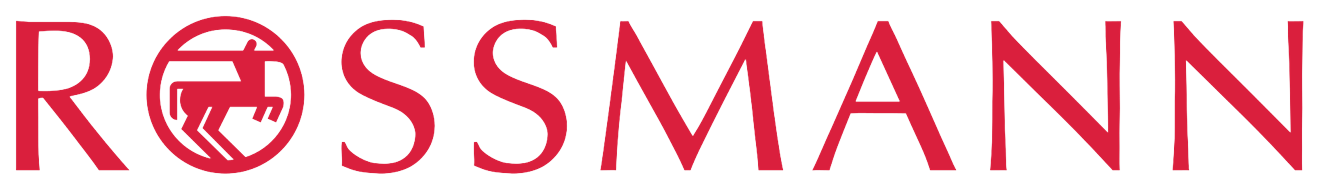

# 1- Contextualização

Rossmann é uma rede de drogarias que opera com mais de 3.000 unidades espelhadas em 7 países da Europa. 

Em uma reunião mensal de apresentação de resultados mensais, o CFO solicitou a todos os gerentes que enviassem um relatório com uma previsão de vendas para as próximas 6 semanas para que ele decida sobre a viabilidade de uma reforma nas lojas.

As lojas são influenciadas por muitos fatores como: Promoções, Competições, Feriados escolas e estaduais, sazonalidade e localidade pois cada loja possui circunstâncias únicas que podem influenciar na variabilidade dos resultados de acurácia do modelo de predição que deverá ser implementado.

# 2- Bibliotecas 

In [ ]:
import pandas as pd
import inflection
import HelpFunctions
import math

# 3- Dados

## 3.1 - Carga

In [ ]:
df_raw1 = pd.read_csv(r'dataset\raw1.csv', low_memory=False)
df_raw2 = pd.read_csv(r'dataset\raw2.csv', low_memory=False)

df_raw = pd.merge(left=df_raw1, right=df_raw2, how='left', on='Store')

In [ ]:
df_raw.sample()

### 3.2 - Descrição dos dados

Colunas / Features | Descrição
:------------------ | :---------:
Store              | Número de identificação da loja. Cada Loja possui um ID único.
Store Type         | Diferencia entre 4 modelos de lojas diferentes: a, b, c, d
Assortment         | Descreve um nível de produtos existentes na loja : a = básico, b = extra, c = estendido
CompetitionDistance | Distância em metros até a loja concorrente mais próxima
CompetitionOpenSinceMonth | O mês aproximado da abertura da loja concorrente mais próxima
CompetitionOpenSinceYear | O ano aproximado da abertura da loja concorrente mais próxima
Promo2 | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando
Promo2SinceWeek | Descreve a semana em que a loja começou a participar do Promo2
Promo2SinceYear | Descreve o ano em que a loja começou a participar do Promo2
PromoInterval | Descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja
DayOfWeek | Dias da semana
Date | Data
Sales | Volume de Vendas para qualquer dia (ESTÁ É A VARIÁVEL TARGET)
Customers | O volume de clientes em um determinado dia
Open | Um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
Promo | Indica se uma loja está realizando uma promoção naquele dia
StateHoliday | Indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum
SchoolHoliday | Indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas

### 3.3 - Renomeando as colunas (Snake Case Type)

In [ ]:
df1 = df_raw.copy()

old_cols = df1.columns

snake_case = lambda x : inflection.underscore(x)

new_cols = list(map(snake_case, old_cols))

df1.columns = new_cols

df1.columns

### 3.4 - Dimensões dos dados

In [ ]:
df1.shape

### 3.5 - Valores Duplicados

In [ ]:
df1 = df1.drop_duplicates()

### 3.6 - Valores NA

In [ ]:
df1.isna().sum()

Observe que, no conjunto de dados, existem algumas colunas e muitas linhas com valores NA. Essas informações faltantes devem ser tratadas de acordo com o negócio.

### 3.6.1 - Analisando as variáveis com dados faltantes

#### VARIÁVEIS: 'competition_distance', 'competition_open_since_month', 'competition_open_since_year'

De acordo com o **NEGÓCIO**, as variáveis estão interligadas e os valores atribuídos as variáveis 'competition_open_since_month', 'competition_open_since_year' dependem do valor da variável 'competition_distance'.

O valor NA da variável 'competition_distance' pode indicar que não há, nas proximidades, lojas concorrentes.

Atribuir valor 0 nesta variável pode ocasionar problemas pois o valor distância 0 metros pode indicar que existe uma loja concorrente com distância menor que 1 metro.

Optei em realizar a seguinte lógica:

    1- Encontrar o valor máximo da coluna 'competition_distance'.
    2- Atribuir aos valores faltantes da variável 'competition_distance' valores 2 x acima da maior distância encontrada na coluna. Garantindo numericamente que não há nenhum concorrente nas proximidades.
    3- Para as colunas 'competition_open_since_month', 'competition_open_since_year':
        3.1 - Se a coluna 'competition_distance' for <= ao valor máximo desta coluna, então eu vou extrair da coluna date o mês e o ano e preencher os valores NA das colunas.
        3.2 - Se a coluna 'competition_distance' for > ao valor máximo desta coluna, então será atrituído o valor 0 pois não há competidores próximos.
        
Antes de realizar esse procedimento é necessário transformar o tipo da coluna 'date' como data 

In [ ]:
# Alterando o tipo da coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

# Encontrando o valor máximo da coluna 'competition distance' e multiplicando por 2
max_distance = df1['competition_distance'].max()

# Atribuindo a variável max_distance nas linhas da coluna 'competition_distance' que possuem valores NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance * 2 if math.isnan(x) else x)

# Verificando a existência de valores NA na variável 'competition_distance' após a atribuição acima
df1['competition_distance'].isna().sum()

In [ ]:
# Removendo valores NA das colunas 'competition_open_since_month' de acordo com a lógica da análise.
for i in df1.index:
    if df1.loc[i,'competition_distance'] > max_distance:
        df1.loc[i,'competition_open_since_month'] = 0

for i in df1.index:
    if (math.isnan(df1.loc[i,'competition_open_since_month'])) & (df1.loc[i,'competition_distance'] <= max_distance):
        df1.loc[i,'competition_open_since_month'] = df1.loc[i,'date'].month
        
# Verificando a existência de valores NA na variável 'competition_open_since_month' após a atribuição acima
df1['competition_open_since_month'].isna().sum()

In [ ]:
# Removendo valores NA das colunas 'competition_open_since_year' de acordo com a lógica da análise.
for i in df1.index:
    if df1.loc[i,'competition_distance'] > max_distance:
        df1.loc[i,'competition_open_since_year'] = 0

for i in df1.index:
    if (math.isnan(df1.loc[i,'competition_open_since_year'])) & (df1.loc[i,'competition_distance'] <= max_distance):
        df1.loc[i,'competition_open_since_year'] = df1.loc[i,'date'].year
        
# Verificando a existência de valores NA na variável 'competition_open_since_year' após a atribuição acima
df1['competition_open_since_year'].isna().sum()

#### VARIÁVEIS: 'promo2_since_week', 'promo2_since_year', 'promo_interval'


Analisar Analisar Analisar Analisar Analisar Analisar Analisar

### 3.7 - Tipo de dados

In [ ]:
df1.dtypes

De acordo com a descrição das colunas no item 3.2 observa-se que o tipo dos dados não corresponde com a descrição: competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year, date, state_holiday estão com o tipo atribuído erroneamente e portanto devem ser alterados.